https://publica-rest.fraunhofer.de/server/api/core/bitstreams/d4913d12-4cd1-473c-97cd-ed467ad19273/content

In [1]:
nodes_file = 'data/03_network-nodes.csv'
edges_file = 'data/04_network-edges.csv'

In [54]:
!pip install pandas networkx scipy lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 28.0 MB/s eta 0:00:0000:0100:01


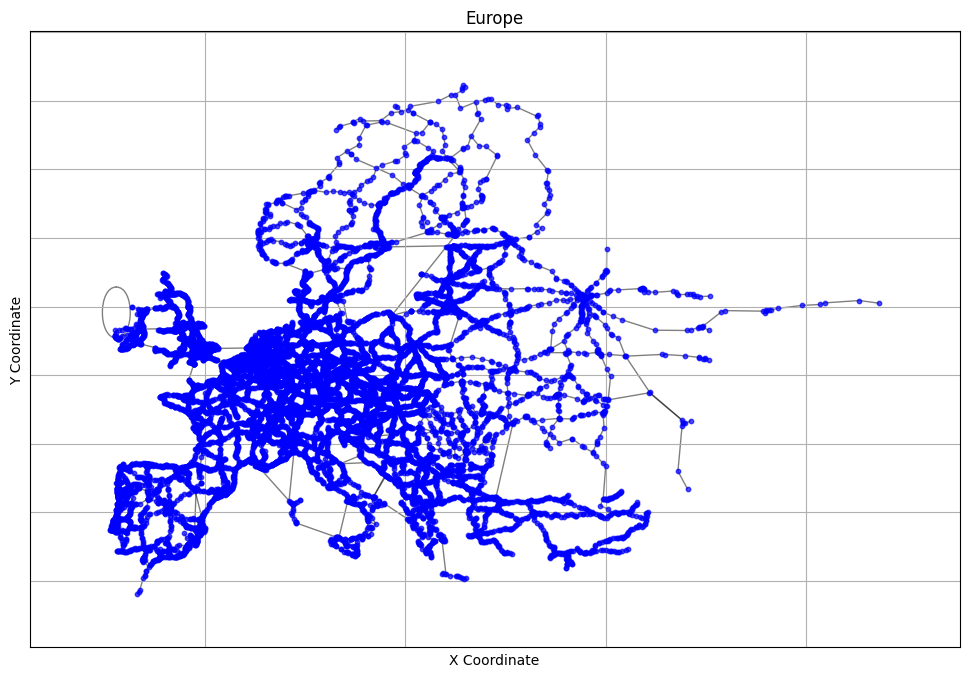

In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Loading the Data
nodes_df = pd.read_csv(nodes_file)
edges_df = pd.read_csv(edges_file)

# Plot the graph
# Create a graph from the edges
G = nx.from_pandas_edgelist(edges_df, 'Network_Node_A_ID', 'Network_Node_B_ID')

# add edge information as attributes to graph
edge_columns = ['Network_Edge_ID', 'Manually_Added', 'Distance', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030']
for index, row in edges_df.iterrows():
    for column in edge_columns:
        G.edges[row['Network_Node_A_ID'], row['Network_Node_B_ID']][column] = row[column]

# Create a position dictionary from node coordinates
pos = {row['Network_Node_ID']: (row['Network_Node_X'], row['Network_Node_Y']) for index, row in nodes_df.iterrows()}

# Plotting the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title('Europe')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [97]:
nodes_df.head()

# unique values of the column country
nodes_df['Country'].unique()

array(['FR', 'ES', 'LU', 'PT', 'BE', 'NL', 'IT', 'DE', 'PL', 'DK', 'AT',
       'CH', 'LI', 'CZ', 'SI', 'HU', 'UK', 'IE', 'TR', 'RO', 'BG', 'GR',
       'MA', 'SK', 'RS', 'MK', 'HR', 'FI', 'SE', 'NO', 'LT', 'AL', 'BA',
       'UA', 'MD', 'BY', 'RU', 'LV', 'EE', 'AM', 'ME', 'KZ'], dtype=object)

In [63]:
edges_df.head()

,Unnamed: 0,Network_Edge_ID,Manually_Added,Distance,Network_Node_A_ID,Network_Node_B_ID,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030
0,0,2604457,0,5.980,262914,260432,0,0
1,1,1013364,0,18.559,262914,109845,0,0
2,2,2604243,0,2.012,262911,109968,1871252,2513351
3,3,1013595,0,4.728,262911,122766,1871252,2513351
4,4,2604354,0,15.028,262909,260001,1038691,1449368


In [158]:
country = 'NL'

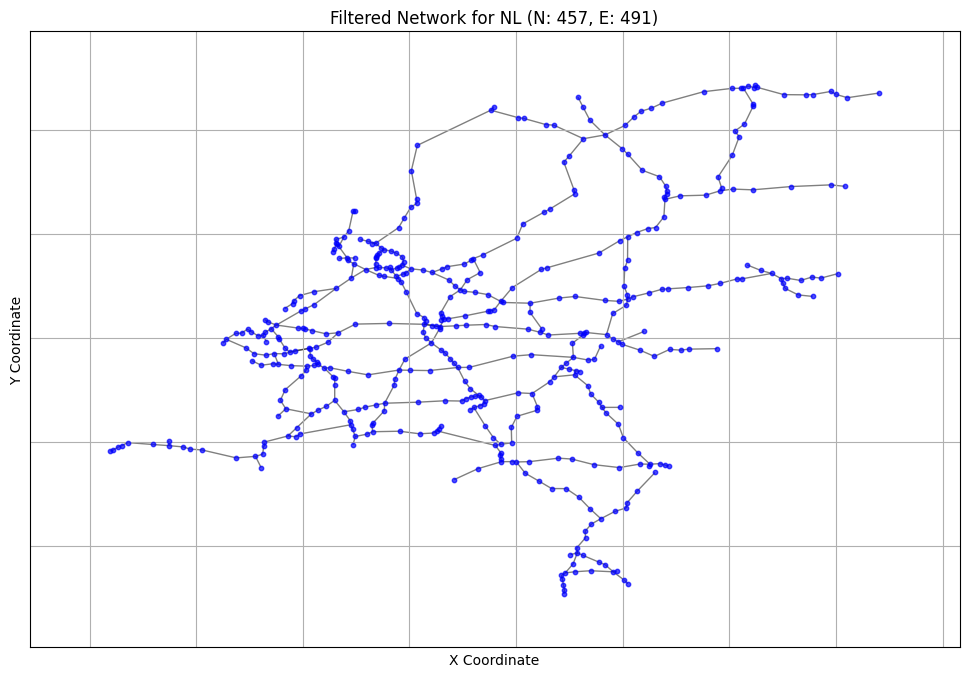

In [159]:
# 2. Filtering for a Specific Country 
filtered_nodes = nodes_df[nodes_df['Country'] == country]
filtered_edges = edges_df[edges_df['Network_Node_A_ID'].isin(filtered_nodes['Network_Node_ID']) & 
                        edges_df['Network_Node_B_ID'].isin(filtered_nodes['Network_Node_ID'])]


# Create a graph from the filtered edges
G_filtered = nx.from_pandas_edgelist(filtered_edges, 'Network_Node_A_ID', 'Network_Node_B_ID')

# add edge information as attributes to graph
edge_columns = ['Network_Edge_ID', 'Manually_Added', 'Distance', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030']
for index, row in filtered_edges.iterrows():
    for column in edge_columns:
        G_filtered.edges[row['Network_Node_A_ID'], row['Network_Node_B_ID']][column] = row[column]

# Create a position dictionary from node coordinates
pos_filtered = {row['Network_Node_ID']: (row['Network_Node_X'], row['Network_Node_Y']) for index, row in filtered_nodes.iterrows()}
# Plotting the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_filtered, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_filtered, pos_filtered, alpha=0.5)

no_nodes = len(G_filtered.nodes)
no_edges = len(G_filtered.edges)

plt.title(f'Filtered Network for {country} (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()



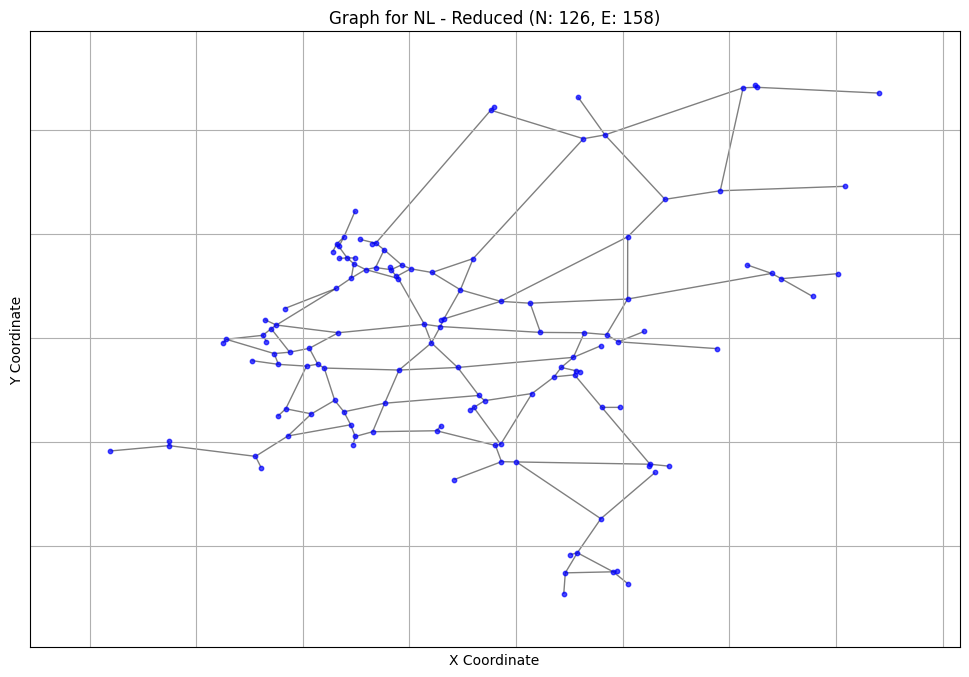

Number of nodes: 126
Number of edges: 158


In [177]:
import yaml

# 3. Iterative Reduction of Nodes
def remove_nodes_and_merge_edges(graph):    
    for edge in graph.edges():
        if 'original' not in graph.edges[edge]:
            graph.edges[edge]['original'] = True
            graph.edges[edge]['node_ids'] = []
            graph.edges[edge]['edge_ids'] = []

    # check that all edges have the original attribute
    assert all(['original' in graph.edges[edge] for edge in graph.edges()])


    while True:
        nodes_with_two_edges = [node for node, degree in dict(graph.degree()).items() if degree == 2]
        if not nodes_with_two_edges:
            break

        for node in nodes_with_two_edges:
            neighbors = list(graph.neighbors(node))
            if len(neighbors) == 2:
                edge_1 = graph.edges[node, neighbors[0]]
                edge_2 = graph.edges[node, neighbors[1]]

                nodes = [node]
                if not edge_1['original']:
                    nodes += edge_1['node_ids']
                if not edge_2['original']:
                    nodes += edge_2['node_ids']	
                
                edges = []
                if not edge_1['original']:
                    edges += edge_1['edge_ids']
                else:
                    edges += [int(edge_1["Network_Edge_ID"])]

                if not edge_2['original']:
                    edges += edge_2['edge_ids']
                else:
                    edges += [int(edge_2["Network_Edge_ID"])]
                
                graph.remove_node(node)

                if not graph.has_edge(neighbors[0], neighbors[1]):
                    graph.add_edge(neighbors[0], neighbors[1])
                    graph.edges[neighbors[0], neighbors[1]]['Distance'] = float(edge_1['Distance'] + edge_2['Distance'])
                    graph.edges[neighbors[0], neighbors[1]]['node_ids'] = nodes
                    graph.edges[neighbors[0], neighbors[1]]['edge_ids'] = edges
                    graph.edges[neighbors[0], neighbors[1]]['original'] = False
                else:
                    # edge already exists, leave the closer one
                    edge_3 = graph.edges[neighbors[0], neighbors[1]]
                    if edge_1['Distance'] + edge_2['Distance'] < edge_3['Distance']:
                        graph.edges[neighbors[0], neighbors[1]]['Distance'] = edge_1['Distance'] + edge_2['Distance']
                        graph.edges[neighbors[0], neighbors[1]]['node_ids'] = nodes
                        graph.edges[neighbors[0], neighbors[1]]['edge_ids'] = edges
                        graph.edges[neighbors[0], neighbors[1]]['original'] = False

    new_edge_info = []
    id = 5_000_000# Highest id in dataset 2616216   
    for edge in graph.edges():
        if not graph.edges[edge]['original']:
            graph.edges[edge]['Network_Edge_ID'] = id
            new_edge_info.append(graph.edges[edge].copy())
            id += 1
        #del graph.edges[edge]['node_ids']
        #del graph.edges[edge]['edge_ids']

    return graph, new_edge_info

G_reduced, new_edge_info = remove_nodes_and_merge_edges(G_filtered.copy())

# 4. Store the Results
#nx.write_graphml_lxml(G_reduced, f'data/graph-{country}-reduced.graphml')

# store new edge information as yaml
with open(f'data/{country}new-edges-reduced.yaml', 'w') as file:
    yaml.dump(new_edge_info, file)

# 5. Plot the Reduced Network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_reduced, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_reduced, pos_filtered, alpha=0.5)

no_nodes = len(G_reduced.nodes())
no_edges = len(G_reduced.edges())

plt.title(f'Graph for {country} - Reduced (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

print(f'Number of nodes: {no_nodes}')
print(f'Number of edges: {no_edges}')
    

In [178]:
threshold = 10

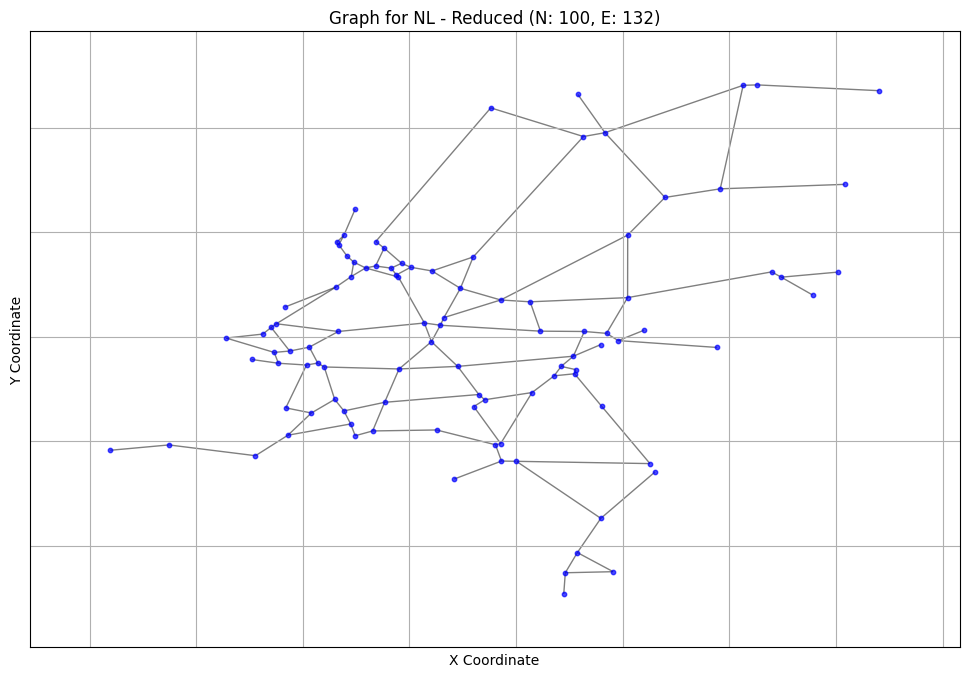

In [179]:
# remove nodes with degree 1 which have an edge with a distanve below threshold

def remove_nodes_with_degree_one(graph, threshold):
    nodes_to_remove = []
    for node in graph.nodes():
        if graph.degree(node) == 1:
            neighbor = list(graph.neighbors(node))[0]
            if graph.edges[node, neighbor]['Distance'] < threshold:
                nodes_to_remove.append(node)
    graph.remove_nodes_from(nodes_to_remove)
    return graph

G_reduced_2 = remove_nodes_with_degree_one(G_reduced.copy(), threshold)

# 6. Plot the Reduced Network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_reduced_2, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_reduced_2, pos_filtered, alpha=0.5)

no_nodes = len(G_reduced_2.nodes())
no_edges = len(G_reduced_2.edges())

plt.title(f'Graph for {country} - Reduced (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

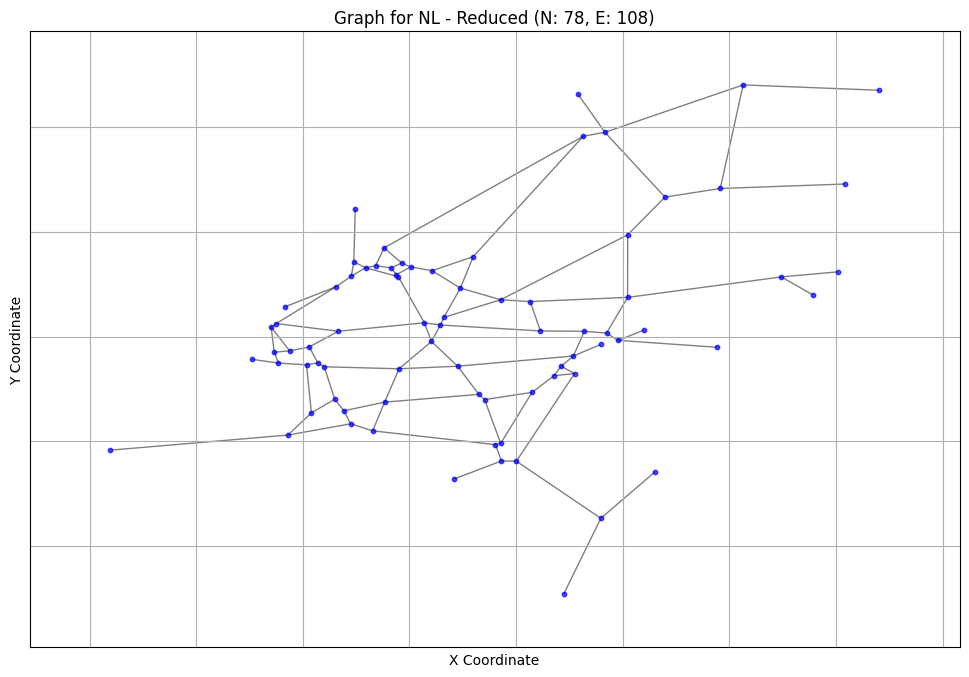

Number of nodes: 78
Number of edges: 108


In [181]:

G_reduced, new_edge_info = remove_nodes_and_merge_edges(G_reduced_2.copy())

# 4. Store the Results
#nx.write_graphml_lxml(G_reduced, f'data/graph-{country}-reduced.graphml')

# store new edge information as yaml
with open(f'data/{country}new-edges-reduced.yaml', 'w') as file:
    yaml.dump(new_edge_info, file)

# 5. Plot the Reduced Network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_reduced, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_reduced, pos_filtered, alpha=0.5)

no_nodes = len(G_reduced.nodes())
no_edges = len(G_reduced.edges())

plt.title(f'Graph for {country} - Reduced (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

print(f'Number of nodes: {no_nodes}')
print(f'Number of edges: {no_edges}')
    

In [182]:
# load 02_NUTS-3-Regions.csv
nuts_regions_file = 'data/02_NUTS-3-Regions.csv'
nuts_regions_df = pd.read_csv(nuts_regions_file)

nuts_regions_df
# ETISPlus_Zone_ID	Name	Country	Geometric_center	Geometric_center_X	Geometric_center_Y	Network_Node_ID

,Unnamed: 0,ETISPlus_Zone_ID,Name,Country,Geometric_center,Geometric_center_X,Geometric_center_Y,Network_Node_ID
0,0,112090100,Guadeloupe,FR,POINT (-61.6763 16.1543),-61.6763,16.15430,106147
1,1,112090200,Martinique,FR,POINT (-61.02 14.636),-61.0200,14.63600,106147
2,2,112090300,French Guiana,FR,POINT (-53.0776 3.95175),-53.0776,3.95175,126354
3,3,127020000,Regiao Autonoma dos Acores,PT,POINT (-25.4934 37.8089),-25.4934,37.80890,106147
4,4,110070003,El Hierro,ES,POINT (-18.0221 27.7437),-18.0221,27.74370,185224
...,...,...,...,...,...,...,...,...
1670,1670,131000203,Nitriansky kraj,SK,POINT (18.3888 48.223),18.3880,48.22300,199617
1671,1671,131000301,Zilinsky kraj,SK,POINT (19.1917 49.1775),19.1917,49.17750,124253
1672,1672,131000302,Banskobystricky kraj,SK,POINT (19.4742 48.5005),19.4742,48.50050,199641
1673,1673,131000401,Presovsky kraj,SK,POINT (21.2239 49.112),21.2230,49.11200,199786


In [183]:
# Filter so only regions which are in the graph or are part of the reduced edges are left
regions_in_graph = nuts_regions_df[nuts_regions_df['Network_Node_ID'].isin(G_filtered.nodes())]
regions_in_graph.head()

,Unnamed: 0,ETISPlus_Zone_ID,Name,Country,Geometric_center,Geometric_center_X,Geometric_center_Y,Network_Node_ID
327,327,124030401,Zeeuwsch-Vlaanderen,NL,POINT (3.79663 51.304),3.79663,51.3040,117019
328,328,124030402,Overig Zeeland,NL,POINT (3.85662 51.5743),3.85662,51.5743,113658
341,341,124030303,Delft en Westland,NL,POINT (4.26768 51.9879),4.26768,51.9879,116990
342,342,124030305,Groot-Rijnmond,NL,POINT (4.29228 51.8525),4.29228,51.8525,113611
345,345,124030302,Agglomeratie 's-Gravenhage,NL,POINT (4.37747 52.0775),4.37747,52.0775,116957


In [ ]:
# load 01_Trucktrafficflow.csv
truck_traffic_file = 'data/01_Trucktrafficflow.csv'
truck_traffic_df = pd.read_csv(truck_traffic_file)

truck_traffic_df